In [2]:
import sys
from os import listdir
from os.path import isfile, join
import pandas as pd
#!{sys.executable} -m pip install tensorflow-gpu==2.4
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/home/bhawks/.conda/envs/dune-1dcnn/lib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

2022-06-22 18:07:21.645850: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-22 18:07:21.653721: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-22 18:07:21.653744: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
from tqdm import trange

# Load data, select ADC

In [9]:
wireplane = "V"
sig_name = wireplane+"-signal"
cln_name = wireplane+"-clnsig"
np.random.seed(42)
nticks = 200
max_mels = 11000
min_edp = 50000
ADC_MIN = 3
ADC_MAX = 10
waveform_scaler = StandardScaler()

def extract_wave(data):
    string = 'tck_'
    waveforms = []
    #Here I extract a column in each iteration and append to list
    for i in range(nticks):
        waveforms.append(data[string+str(i)].astype(np.int16))
    #convert to numpy ndarray
    waveforms = np.array(waveforms).astype(np.int16)
    #since raws and columns are inverted we need to transpose it
    return np.transpose(waveforms)

def extract_peak(data):
    #extract index of peak
    idx = np.array([data['stp0'], data['adc0'], data['stp1'], data['adc1'], data['stp2'], data['adc2'], data['stp3'], data['adc3'], data['stp4'], data['adc4']])
    #same as before
    return np.transpose(idx)

def extract_peak_info(data):
    peaks_pos = [data['stp0'], data['stp1'], data['stp2'], data['stp3'], data['stp4']]
    adcs = [data['adc0'], data['adc1'], data['adc2'], data['adc3'], data['adc4']]
    return np.array(peaks_pos).T, np.array(adcs).T

def extract_nel_info(data):
    nels = [data['nel0'], data['nel1'], data['nel2'], data['nel3'], data['nel4']]
    return np.array(nels).T

def extract_edp_info(data):
    edp = [data['edp0'], data['edp1'], data['edp2'], data['edp3'], data['edp4']]
    return np.array(edp).T

def filter_signals(data, clean_data, filter_adc_max=True):
    #edp_mask = np.all(extract_edp_info(data)>min_edp, axis = 1)
    #nel_mask = np.all(extract_nel_info(data)<max_mels, axis = 1)
    #pd.DataFrame(np.all(extract_edp_info(data)>min_edp, axis = 1)).describe()
    #print(edp_mask)
    #print(nel_mask)
    #filter_mask = nel_mask #np.logical_and(edp_mask,nel_mask) 
    filtered_data = data#[filter_mask]
    cln_filtered_data = clean_data#[filter_mask]
    
    filtered_peak = extract_peak_info(cln_filtered_data)[1]
    if filter_adc_max:
        peak_mask = np.any(filtered_peak>ADC_MIN, axis = 1)
        peak_mask &= np.any(filtered_peak<ADC_MAX, axis = 1)
    else:
        peak_mask = np.any(filtered_peak>ADC_MIN, axis = 1)
    
    filtered_data = filtered_data[peak_mask]
    cln_filtered_data = cln_filtered_data[peak_mask]
    
    return filtered_data, cln_filtered_data, filtered_peak

def get_std_waveforms(data):
    #Extract and scale waveform data (passthrough rn)
    raw_waveforms = extract_wave(data)
    #print(raw_waveforms) 
    #scaled_waveforms = waveform_scaler.fit_transform(raw_waveforms)
    return raw_waveforms

In [11]:
#X = np.load("data/X_argoneut.npz")
#y = np.load("data/y_argoneut.npz")
#old_peak = np.load("peak_argoneut.npz")

#Load Training Data
path = "/home/bhawks/dunesnb/1dcnn/train/train/nu_cc/"
path2 = "/home/bhawks/dunesnb/1dcnn/train/train/nu_es/"
filenames1 = [path+f for f in listdir(path) if (isfile(join(path, f)) and sig_name in f)]
clean_filenames1 = [path+f for f in listdir(path) if (isfile(join(path, f)) and cln_name in f)]
filenames2 = [path2+f for f in listdir(path2) if (isfile(join(path2, f)) and sig_name in f)]
clean_filenames2 = [path2+f for f in listdir(path2) if (isfile(join(path2, f)) and cln_name in f)]

filenames =  filenames1+filenames2
clean_filenames = clean_filenames1+clean_filenames2

combined_data = np.concatenate([np.load(fname) for fname in filenames])
combined_clean_data = np.concatenate([np.load(fname) for fname in filenames])

noise_path = "/home/bhawks/dunesnb/1dcnn/train/train/noise/"
noise_filenames = [f for f in listdir(noise_path) if (isfile(join(noise_path, f)) and sig_name in f)]
#print(noise_filenames)
noise_clean_filenames = [f for f in listdir(noise_path) if (isfile(join(noise_path, f)) and cln_name in f)]

combined_noise = np.concatenate([np.load(noise_path+fname) for fname in noise_filenames])
#print(combined_noise)
#combined_clean_noise = np.concatenate([np.load(noise_path+fname) for fname in noise_clean_filenames])



IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



# Train/Noise Data Preprocessing



In [12]:
from sklearn.utils import shuffle
print("Unfiltered:" + str(combined_data.shape[0]))
#Filter out tiny signals < ADC_MIN, but leave big signals to test on (> ADC_MAX)
combined_data, combined_clean_data, peak = filter_signals(combined_data, combined_clean_data, False)
print("> ADC_MIN:" + str(combined_data.shape[0]))

#split train and test sets (~50k ea before filtering) 
combined_data, x_test_data, combined_clean_data, x_test_clean  = train_test_split(
    combined_data, combined_clean_data, test_size=0.5, shuffle=True
)
print("Train Split:" + str(combined_data.shape[0]))
#filter data and extract waveforms of filtered data
combined_data, combined_clean_data, peak = filter_signals(combined_data, combined_clean_data, True)
signal_waveforms = get_std_waveforms(combined_data)
print("Train Split Filtered ADC_MIN < x < ADC_MAX:" + str(combined_data.shape[0]))
#extract waveforms of noise
noise_waveforms = get_std_waveforms(combined_noise)

#extract waveforms of test data
test_signal_waveforms = get_std_waveforms(x_test_data)
print("Test Set:" + str(test_signal_waveforms.shape[0]))
#generate y data (assuming all radiologicals contain signal, all noise does not)
y_noise_full = np.zeros(noise_waveforms.shape[0])
y_signal = np.ones(signal_waveforms.shape[0])
y_test_signal = np.ones(test_signal_waveforms.shape[0])


# split test and train noise datasets (50k)
x_noise_train, x_noise_test, y_noise_train, y_noise_test = train_test_split(
    noise_waveforms, y_noise_full, test_size=0.5, shuffle=True
)

#Shuffle signal waveforms to be safe
signal_waveforms, y_signal = shuffle(signal_waveforms,y_signal)

#Shuffle test waveformst to be safe
x_test, y_test = shuffle(test_signal_waveforms,y_test_signal)

#Select First n signal samples from (shuffled) set of signals where n = noise samples for balanced train set 
x_train = np.concatenate((signal_waveforms[:int(x_noise_train.shape[0])], x_noise_train))
y_train = np.concatenate((y_signal[:int(x_noise_train.shape[0])], y_noise_train))
x_test = np.concatenate((x_test[:int(x_noise_test.shape[0])], x_noise_test))
y_test = np.concatenate((y_test_signal[:int(x_noise_test.shape[0])], y_noise_test))


# extra train shuffle for good measure 
x_train, y_train = shuffle(x_train,y_train)

# extra test shuffle for good measure 
x_test, y_test = shuffle(x_test,y_test)

#split train and valid sets (40k train 10k valid) 
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=0.2, shuffle=True
)

Unfiltered:231744
> ADC_MIN:130731
Train Split:65365
Train Split Filtered ADC_MIN < x < ADC_MAX:62245
Test Set:65366


# Load Test Data

In [6]:
'''
#Load Test Data
cc_path = "/home/bhawks/dunesnb/1dcnn/train/train/nu_cc/"
cc_filenames = [f for f in listdir(cc_path) if (isfile(join(cc_path, f)) and sig_name in f)]
cc_clean_filenames = [f for f in listdir(cc_path) if (isfile(join(cc_path, f)) and cln_name in f)]

es_path = "/home/bhawks/dunesnb/1dcnn/train/train/nu_es/"
es_filenames = [f for f in listdir(es_path) if (isfile(join(es_path, f)) and sig_name in f)]
es_clean_filenames = [f for f in listdir(es_path) if (isfile(join(es_path, f)) and cln_name in f)]

cc_combined_data = np.concatenate([np.load(cc_path+fname) for fname in cc_filenames])
es_combined_data = np.concatenate([np.load(es_path+fname) for fname in es_filenames])

cc_combined_clean_data = np.concatenate([np.load(cc_path+fname) for fname in cc_filenames])
es_combined_clean_data= np.concatenate([np.load(es_path+fname) for fname in es_filenames])
'''

'\n#Load Test Data\ncc_path = "/home/bhawks/dunesnb/1dcnn/train/train/nu_cc/"\ncc_filenames = [f for f in listdir(cc_path) if (isfile(join(cc_path, f)) and sig_name in f)]\ncc_clean_filenames = [f for f in listdir(cc_path) if (isfile(join(cc_path, f)) and cln_name in f)]\n\nes_path = "/home/bhawks/dunesnb/1dcnn/train/train/nu_es/"\nes_filenames = [f for f in listdir(es_path) if (isfile(join(es_path, f)) and sig_name in f)]\nes_clean_filenames = [f for f in listdir(es_path) if (isfile(join(es_path, f)) and cln_name in f)]\n\ncc_combined_data = np.concatenate([np.load(cc_path+fname) for fname in cc_filenames])\nes_combined_data = np.concatenate([np.load(es_path+fname) for fname in es_filenames])\n\ncc_combined_clean_data = np.concatenate([np.load(cc_path+fname) for fname in cc_filenames])\nes_combined_clean_data= np.concatenate([np.load(es_path+fname) for fname in es_filenames])\n'

# Test Data Pre-Processing

In [7]:
'''
cc_combined_data, cc_combined_clean_data, cc_peak = filter_signals(cc_combined_data, cc_combined_clean_data)
es_combined_data, es_combined_clean_data, es_peak = filter_signals(es_combined_data, es_combined_clean_data)

cc_signal_waveforms = get_std_waveforms(cc_combined_data)
es_signal_waveforms = get_std_waveforms(es_combined_data)

cc_y_signal = np.ones(cc_signal_waveforms.shape[0])
es_y_signal = np.ones(es_signal_waveforms.shape[0])

#Select First n signal samples from (shuffled) set of signals where n = noise samples for balanced test 
cc_x_test = np.concatenate((cc_signal_waveforms[:int(x_noise_test.shape[0])], x_noise_test))
cc_y_test = np.concatenate((cc_y_signal[:int(x_noise_test.shape[0])], y_noise_test))

#Select First n signal samples from (shuffled) set of signals where n = noise samples for balanced test 
es_x_test = np.concatenate((es_signal_waveforms[:int(x_noise_test.shape[0])], x_noise_test))
es_y_test = np.concatenate((es_y_signal[:int(x_noise_test.shape[0])], y_noise_test))

#shuffle for good measure 
from sklearn.utils import shuffle
cc_x_test, cc_y_test = shuffle(cc_x_test,cc_y_test)
es_x_test, es_y_test = shuffle(es_x_test,es_y_test)
'''

'\ncc_combined_data, cc_combined_clean_data, cc_peak = filter_signals(cc_combined_data, cc_combined_clean_data)\nes_combined_data, es_combined_clean_data, es_peak = filter_signals(es_combined_data, es_combined_clean_data)\n\ncc_signal_waveforms = get_std_waveforms(cc_combined_data)\nes_signal_waveforms = get_std_waveforms(es_combined_data)\n\ncc_y_signal = np.ones(cc_signal_waveforms.shape[0])\nes_y_signal = np.ones(es_signal_waveforms.shape[0])\n\n#Select First n signal samples from (shuffled) set of signals where n = noise samples for balanced test \ncc_x_test = np.concatenate((cc_signal_waveforms[:int(x_noise_test.shape[0])], x_noise_test))\ncc_y_test = np.concatenate((cc_y_signal[:int(x_noise_test.shape[0])], y_noise_test))\n\n#Select First n signal samples from (shuffled) set of signals where n = noise samples for balanced test \nes_x_test = np.concatenate((es_signal_waveforms[:int(x_noise_test.shape[0])], x_noise_test))\nes_y_test = np.concatenate((es_y_signal[:int(x_noise_test.s

In [8]:
#pd.DataFrame(extract_nel_info(combined_data)).describe()

In [9]:
#pd.DataFrame(old_peak["training_set"]).describe()


In [10]:
#for i in range(0,5): 
#    plt.hist(peak[:,i],bins=120)
#    plt.show()
#pd.DataFrame(peak).describe()

In [11]:
#for i in range(0,5): 
#    plt.hist(unscaled_peak[:,i],bins=120)
#    plt.show()
#pd.DataFrame(unscaled_peak).describe()

In [12]:
#x_train = X["training_set"]
#y_train = y["training_set"]#
#x_test = X["test_set"]
#y_test = y["test_set"]

#peak_train = peak["training_set"]
#peak_test = peak["test_set"]
#del y
#del X
#del peak

In [13]:
#ADC_MIN = 3

In [14]:
#signal = x_train[y_train == 1]
#noise = x_train[y_train == 0]

#peak_signal = peak_train[y_train == 1]
#peak_noise =  peak_train[y_train == 0]

In [15]:
#signal_test = x_test[y_test == 1]
#noise_test = x_test[y_test == 0]

#peak_signal_test = peak_test[y_test == 1]
#peak_noise_test =  peak_test[y_test == 0]

In [16]:
#mask = np.any(peak_signal>ADC_MIN, axis = 1)
#peak_signal = signal[mask]
#signal = signal[mask]

In [17]:
#mask = np.any(peak_signal_test>ADC_MIN, axis = 1)
#peak_signal_test = signal_test[mask]
#signal_test = signal_test[mask]

In [18]:
#y_noise = np.zeros(signal.shape[0])
#y_signal = np.ones(signal.shape[0])

#x_train = np.concatenate((noise[:signal.shape[0]], signal))
#y_train = np.concatenate((y_noise, y_signal))
#from sklearn.utils import shuffle
#x_train, y_train = shuffle(x_train,y_train)

In [19]:
#y_noise_test = np.zeros(signal_test.shape[0])
#y_signal_test = np.ones(signal_test.shape[0])

#x_test = np.concatenate((noise_test[:signal_test.shape[0]], signal_test))
#y_test = np.concatenate((y_noise_test, y_signal_test))
#from sklearn.utils import shuffle
#x_test, y_test = shuffle(x_test,y_test)

In [20]:
x_train.shape

(86880, 200)

In [21]:
x_valid.shape

(21720, 200)

In [22]:
mean = x_train.mean()
std = x_train.std()

In [23]:
x_train_scaled = (x_train-mean)/std
x_valid_scaled = (x_valid-mean)/std
x_test_scaled = (x_test-mean)/std
#cc_x_test_scaled = (cc_x_test-mean)/std 
#es_x_test_scaled = (es_x_test-mean)/std 
time_periods = 200

In [24]:
np.save("models/mean_v_nu", mean)
np.save("models/scale_v_nu", std)

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, \
    Dropout, Dense,Flatten, AveragePooling1D, BatchNormalization

In [26]:
time_periods = 200
def create_model():
  model = Sequential()  
  #first convolutional block
  model.add(Conv1D(filters=16, kernel_size=3, strides=2, activation = "relu", input_shape=(time_periods,1)))
  model.add(MaxPooling1D(pool_size=2))

  #second convolutional block
  model.add(Conv1D(filters=32, kernel_size=5, strides=2, activation = "relu"))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.1))
  
  #forth convolutional block
  model.add(Conv1D(filters=64, kernel_size=9, activation = "relu"))
  model.add(GlobalMaxPooling1D())
  model.add(Dropout(0.2)) 
    
  model.add(Flatten())

  
 
  model.add(Dense(1, activation="sigmoid", name="wavrec_out"))
  return model


model = create_model()

#lr=0.001
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 99, 16)            64        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 16)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 23, 32)            2592      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 11, 32)           0         
 1D)                                                             
                                                                 
 dropout (Dropout)           (None, 11, 32)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 3, 64)             1

2022-06-09 19:34:23.532773: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-09 19:34:23.534281: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-09 19:34:23.534472: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-06-09 19:34:23.534676: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-06-09 19:34:23.534901: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [27]:
x_train_scaled = x_train_scaled.reshape(x_train_scaled.shape[0], x_train_scaled.shape[1], 1)
#cc_x_test_scaled = cc_x_test_scaled.reshape(cc_x_test_scaled.shape[0], cc_x_test_scaled.shape[1], 1)
#es_x_test_scaled = es_x_test_scaled.reshape(es_x_test_scaled.shape[0], es_x_test_scaled.shape[1], 1)
x_valid_scaled = x_valid_scaled.reshape(x_valid_scaled.shape[0], x_valid_scaled.shape[1], 1)
x_test_scaled = x_test_scaled.reshape(x_test_scaled.shape[0], x_test_scaled.shape[1], 1)

In [28]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)


In [29]:
%%time
history = model.fit(x_train_scaled,                                                              
                    y_train,                                                            
                    batch_size=2048,                                              
                    epochs=100,      
                    
                   # epochs=30, 
                    #epochs = 6,
                    callbacks=[earlystop],
                     # callbacks=callbacks_list,                         
                    validation_data=(x_valid_scaled, y_valid),                                               
                    verbose=1)   

Epoch 1/100
43/43 [==============================] - 3s 51ms/step - loss: 0.5354 - accuracy: 0.6543 - val_loss: 0.3912 - val_accuracy: 0.8649
Epoch 2/100
43/43 [==============================] - 2s 35ms/step - loss: 0.3241 - accuracy: 0.8745 - val_loss: 0.2710 - val_accuracy: 0.8957
Epoch 3/100
43/43 [==============================] - 2s 36ms/step - loss: 0.2742 - accuracy: 0.8919 - val_loss: 0.2559 - val_accuracy: 0.9012
Epoch 4/100
43/43 [==============================] - 2s 36ms/step - loss: 0.2630 - accuracy: 0.8970 - val_loss: 0.2490 - val_accuracy: 0.9051
Epoch 5/100
43/43 [==============================] - 1s 35ms/step - loss: 0.2567 - accuracy: 0.9012 - val_loss: 0.2444 - val_accuracy: 0.9076
Epoch 6/100
43/43 [==============================] - 1s 35ms/step - loss: 0.2538 - accuracy: 0.9019 - val_loss: 0.2425 - val_accuracy: 0.9076
Epoch 7/100
43/43 [==============================] - 2s 35ms/step - loss: 0.2518 - accuracy: 0.9031 - val_loss: 0.2410 - val_accuracy: 0.9081
Epoch 

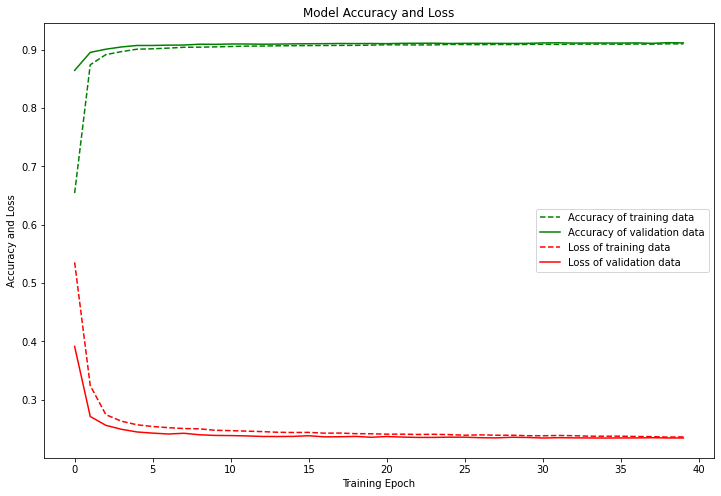

In [30]:
plt.figure(figsize=(12, 8))                                                     
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data", antialiased=True)
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data", antialiased=True)
plt.plot(history.history['loss'], "r--", label="Loss of training data", antialiased=True)
plt.plot(history.history['val_loss'], "r", label="Loss of validation data", antialiased=True)
plt.title('Model Accuracy and Loss')                                            
plt.ylabel('Accuracy and Loss')                                                 
plt.xlabel('Training Epoch')                                                    
#plt.ylim(0)                                                                     
plt.legend()                                                                    
plt.show()     

In [31]:
#del x_train

import gc
gc.collect()

5305

In [32]:
model.save("models/vplane_nu.h5")

In [33]:
history.history['loss']

[0.5354440212249756,
 0.3240804672241211,
 0.2741560637950897,
 0.26295334100723267,
 0.25674450397491455,
 0.2538227438926697,
 0.25183650851249695,
 0.250310480594635,
 0.24981650710105896,
 0.2473600208759308,
 0.24672004580497742,
 0.24587704241275787,
 0.24506984651088715,
 0.24395394325256348,
 0.24354106187820435,
 0.24372468888759613,
 0.2423694133758545,
 0.2425718754529953,
 0.241555318236351,
 0.2413417249917984,
 0.24067921936511993,
 0.24068760871887207,
 0.24017028510570526,
 0.24045266211032867,
 0.23991580307483673,
 0.23886847496032715,
 0.23947745561599731,
 0.23887766897678375,
 0.23885351419448853,
 0.23804880678653717,
 0.23791101574897766,
 0.2384253889322281,
 0.23803481459617615,
 0.23715394735336304,
 0.23716965317726135,
 0.2371881753206253,
 0.2366843968629837,
 0.23645690083503723,
 0.2356342375278473,
 0.23602095246315002]

In [34]:
history.history['val_loss']

[0.3911876976490021,
 0.27099958062171936,
 0.25585153698921204,
 0.24903222918510437,
 0.24443319439888,
 0.2424726039171219,
 0.2409544289112091,
 0.24219952523708344,
 0.23963287472724915,
 0.23852543532848358,
 0.23823808133602142,
 0.23770691454410553,
 0.23674660921096802,
 0.23666343092918396,
 0.23686476051807404,
 0.2379533052444458,
 0.23607952892780304,
 0.23624980449676514,
 0.23680898547172546,
 0.23539778590202332,
 0.2365734726190567,
 0.23568490147590637,
 0.23506012558937073,
 0.23510684072971344,
 0.2355145663022995,
 0.23546479642391205,
 0.23460698127746582,
 0.23429358005523682,
 0.23534072935581207,
 0.23498454689979553,
 0.2341012805700302,
 0.23459333181381226,
 0.23434287309646606,
 0.23414605855941772,
 0.23403695225715637,
 0.2341959923505783,
 0.23420940339565277,
 0.23456116020679474,
 0.23411963880062103,
 0.2341488003730774]

In [35]:
history.history['accuracy']

[0.6543393135070801,
 0.8745050430297852,
 0.8919199109077454,
 0.897041916847229,
 0.9012200832366943,
 0.9018991589546204,
 0.9030731916427612,
 0.9045004844665527,
 0.9046846032142639,
 0.9051795601844788,
 0.9058356285095215,
 0.9064571857452393,
 0.9066067934036255,
 0.907021164894104,
 0.9072283506393433,
 0.9074355363845825,
 0.9075736403465271,
 0.9077578186988831,
 0.9078153967857361,
 0.9081721901893616,
 0.908805251121521,
 0.9085865616798401,
 0.9085289835929871,
 0.9085635542869568,
 0.9094268083572388,
 0.9092541337013245,
 0.9089779257774353,
 0.9094038009643555,
 0.9091160297393799,
 0.9094038009643555,
 0.9096570014953613,
 0.9094153046607971,
 0.9099447727203369,
 0.9098526835441589,
 0.9100943803787231,
 0.9096800088882446,
 0.9100598692893982,
 0.9098641872406006,
 0.9103821516036987,
 0.9102670550346375]

In [36]:
history.history['val_accuracy']

[0.864871084690094,
 0.8957182168960571,
 0.901197075843811,
 0.9050644636154175,
 0.9075967073440552,
 0.9075967073440552,
 0.9081491827964783,
 0.9083333611488342,
 0.909760594367981,
 0.909576416015625,
 0.9101288914680481,
 0.9101288914680481,
 0.909760594367981,
 0.9099447727203369,
 0.910405158996582,
 0.910589337348938,
 0.9107274413108826,
 0.9110037088394165,
 0.9108655452728271,
 0.9109576344490051,
 0.9107274413108826,
 0.9112799167633057,
 0.9113720059394836,
 0.9115101099014282,
 0.9110037088394165,
 0.9112799167633057,
 0.9112799167633057,
 0.9112339019775391,
 0.9110957384109497,
 0.9112339019775391,
 0.9119705557823181,
 0.9122007489204407,
 0.9117403030395508,
 0.9117863774299622,
 0.9118323922157288,
 0.9117403030395508,
 0.9120165705680847,
 0.9112799167633057,
 0.9123849272727966,
 0.9120625853538513]

In [37]:
model.evaluate(x_test_scaled, y_test, batch_size=4096)

27/27 [==============================] - 1s 19ms/step - loss: 0.2264 - accuracy: 0.9135


[0.22638656198978424, 0.9134898781776428]

In [38]:
#model.evaluate(es_x_test_scaled, es_y_test, batch_size=4096)

In [39]:
x_train_ = x_train_scaled
y_train_ = y_train

x_valid_ = x_valid_scaled
y_valid_ = y_valid


# Train

In [40]:
%%time
%matplotlib inline
import seaborn as sns
infer = model.predict(x_train_, batch_size=4096)

22/22 [==============================] - 1s 19ms/step
CPU times: user 2.84 s, sys: 157 ms, total: 3 s
Wall time: 916 ms


<AxesSubplot:>

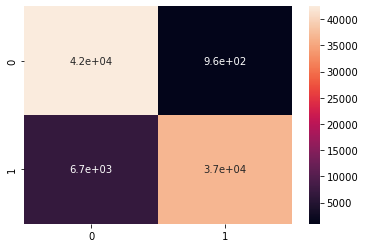

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_train_, infer>0.5)
sns.heatmap(cm, annot=True)

<AxesSubplot:>

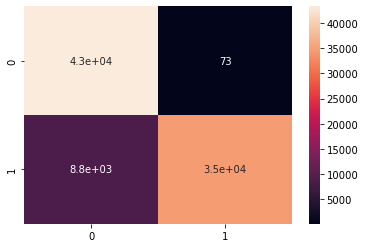

In [42]:
from sklearn.metrics import confusion_matrix
cm2 = confusion_matrix(y_train_, infer>0.9)
sns.heatmap(cm2, annot=True)

In [43]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_train_, infer)

In [44]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [45]:
np.save("results/false_positive_V_train", fpr_keras)
np.save("results/true_positive_V_train", tpr_keras)
np.save("results/thresholds_V_train", thresholds_keras)

In [46]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

# Valid

In [47]:
%%time
infer = model.predict(x_valid_, batch_size=4096)

6/6 [==============================] - 0s 18ms/step
CPU times: user 742 ms, sys: 23.3 ms, total: 765 ms
Wall time: 186 ms


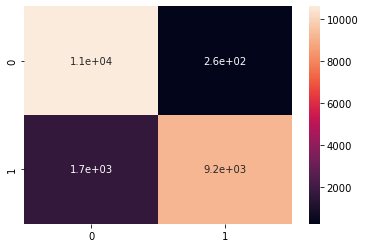

In [48]:
from sklearn.metrics import confusion_matrix
cmv = confusion_matrix(y_valid_, infer>0.5)
sns.heatmap(cmv, annot=True)
plt.show()

<AxesSubplot:>

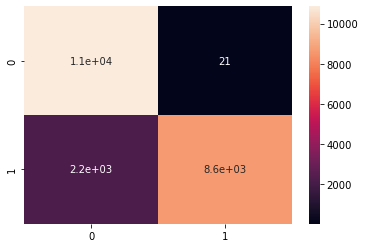

In [49]:
from sklearn.metrics import confusion_matrix
cmv2 = confusion_matrix(y_valid_, infer>0.9)
sns.heatmap(cmv2, annot=True)

In [50]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_valid_, infer)

In [51]:
np.save("results/false_positive_V_valid", fpr_keras)
np.save("results/true_positive_V_valid", tpr_keras)
np.save("results/thresholds_V_valid", thresholds_keras)

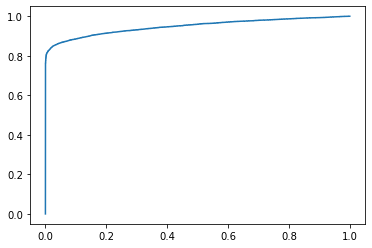

In [52]:
plt.plot(fpr_keras, tpr_keras)

# test

In [53]:
'''
radio_model = tf.keras.models.load_model("models/vplane_radio.h5")
radio_mean = np.load("models/mean_radio.npy")
radio_scale = np.load("models/scale_radio.npy")
x_test_radio_scaled = (x_test-radio_mean)/radio_scale
x_test_radio_scaled = x_test_radio_scaled.reshape(x_test_radio_scaled.shape[0], x_test_radio_scaled.shape[1], 1)
radio_infer = radio_model.predict(x_test_radio_scaled, batch_size=4096)
model.evaluate(x_test_scaled, y_test, batch_size=4096)
'''

'\nradio_model = tf.keras.models.load_model("models/vplane_radio.h5")\nradio_mean = np.load("models/mean_radio.npy")\nradio_scale = np.load("models/scale_radio.npy")\nx_test_radio_scaled = (x_test-radio_mean)/radio_scale\nx_test_radio_scaled = x_test_radio_scaled.reshape(x_test_radio_scaled.shape[0], x_test_radio_scaled.shape[1], 1)\nradio_infer = radio_model.predict(x_test_radio_scaled, batch_size=4096)\nmodel.evaluate(x_test_scaled, y_test, batch_size=4096)\n'

In [54]:
#%%time
#cc_infer = model.predict(cc_x_test_scaled, batch_size=4096)
#es_infer = model.predict(es_x_test_scaled, batch_size=4096)
all_infer = model.predict(x_test_scaled, batch_size=4096)
all_y_test = y_test


27/27 [==============================] - 1s 18ms/step


In [55]:
from sklearn.metrics import confusion_matrix
#cc1 = confusion_matrix(cc_y_test, cc_infer>0.5)
#sns.heatmap(cc1, annot=True)

In [56]:
#es1 = confusion_matrix(es_y_test, es_infer>0.5)
#sns.heatmap(es1, annot=True)

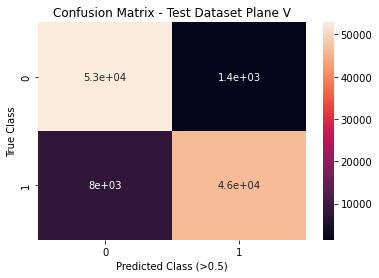

In [57]:
all1 = confusion_matrix(all_y_test, all_infer>0.5)
sns.heatmap(all1, annot=True)
plt.title("Confusion Matrix - Test Dataset Plane " + wireplane)
plt.xlabel("Predicted Class (>0.5)")
plt.ylabel("True Class")
plt.show()

In [58]:
from sklearn.metrics import confusion_matrix
#cc2 = confusion_matrix(cc_y_test, cc_infer>0.9)
#sns.heatmap(cc2, annot=True)

In [59]:
#es2 = confusion_matrix(es_y_test, es_infer>0.9)
#sns.heatmap(es2, annot=True)

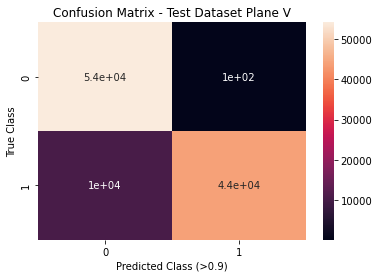

In [60]:
all2 = confusion_matrix(all_y_test, all_infer>0.9)
sns.heatmap(all2, annot=True)
plt.title("Confusion Matrix - Test Dataset Plane " + wireplane)
plt.xlabel("Predicted Class (>0.9)")
plt.ylabel("True Class")
plt.show()

In [61]:
from sklearn.metrics import roc_curve
#fpr_keras, tpr_keras, thresholds_keras = roc_curve(cc_y_test, cc_infer)
#plt.plot(fpr_keras, tpr_keras)

In [62]:
#fpr_keras, tpr_keras, thresholds_keras = roc_curve(es_y_test, es_infer)
#plt.plot(fpr_keras, tpr_keras)

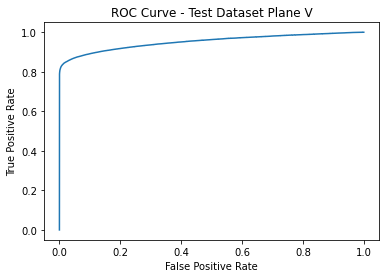

In [63]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(all_y_test, all_infer)
plt.plot(fpr_keras, tpr_keras)
plt.title("ROC Curve - Test Dataset Plane " + wireplane)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [64]:
np.save("results/false_positive_V_test", fpr_keras)
np.save("results/true_positive_V_test", tpr_keras)
np.save("results/thresholds_V_test", thresholds_keras)

In [65]:
#plt.hist(cc_infer, bins = 100);

In [66]:
#plt.hist(es_infer, bins = 100);

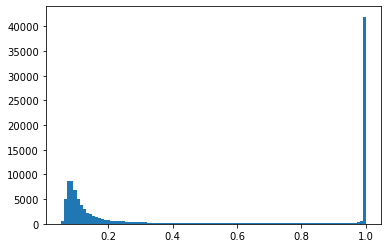

In [67]:
plt.hist(all_infer, bins = 100);

In [68]:
%%time
#cc_infer_signal = model.predict(cc_x_test_scaled[cc_y_test==1], batch_size=4096)
#cc_infer_noise = model.predict(cc_x_test_scaled[cc_y_test==0], batch_size=4096)
#es_infer_signal = model.predict(es_x_test_scaled[es_y_test==1], batch_size=4096)
#es_infer_noise = model.predict(es_x_test_scaled[es_y_test==0], batch_size=4096)
all_infer_signal = model.predict(x_test_scaled[y_test==1], batch_size=4096)
all_infer_noise = model.predict(x_test_scaled[y_test==0], batch_size=4096)

14/14 [==============================] - 0s 18ms/step
CPU times: user 3.6 s, sys: 310 ms, total: 3.91 s
Wall time: 975 ms


In [69]:
#plt.hist(cc_infer_noise, range = (0,1), bins=20)

In [70]:
#plt.hist(es_infer_noise, range = (0,1), bins=20)

(array([    0., 27150., 14754.,  4881.,  2322.,  1361.,   946.,   641.,
          447.,   360.,   297.,   257.,   191.,   162.,   137.,   121.,
           94.,    74.,    62.,    43.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       dtype=float32),
 <BarContainer object of 20 artists>)

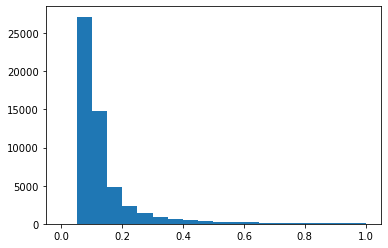

In [71]:
plt.hist(all_infer_noise, range = (0,1), bins=20)

In [72]:
#plt.hist(cc_infer_signal, range = (0,1), bins=20)

In [73]:
#plt.hist(es_infer_signal, range = (0,1), bins=20)

(array([    0.,  2016.,  2133.,  1097.,   752.,   533.,   422.,   368.,
          332.,   304.,   233.,   232.,   265.,   250.,   274.,   321.,
          384.,   418.,   656., 43310.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       dtype=float32),
 <BarContainer object of 20 artists>)

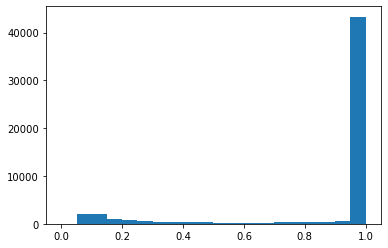

In [74]:
plt.hist(all_infer_signal, range = (0,1), bins=20)